My goal here will be to create some initial recommendations for a fake user. Let's create a persona.
First, I'll create a list of their top-5-ranked-wines, by id:

## 1. Setup of wine data and our fake user

In [15]:
# set up
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wines = pd.read_csv('/Users/erinberridge/blendbud/wine_data3.csv')
wines.set_index("id", inplace=True)

In [3]:
top5_ids = [1386686,5177761,1649800,8890662,93974]
df_top5 = wines.loc[top5_ids]
print(df_top5)

                                               name                  type  \
id                                                                          
1386686                            Ribera del Duero  Ribera Del Duero Red   
5177761  Castillo Ygay Gran Reserva Especial Blanco           Rioja White   
1649800     Premiere Napa Valley Cabernet Sauvignon    Cabernet Sauvignon   
8890662                                   Ancestral  Ribera Del Duero Red   
93974                                        Zeus I        Bordeaux Blend   

          acidity  fizziness  intensity  sweetness    tannin      flavor1  \
id                                                                          
1386686  3.722730        NaN   3.898362   1.729622  3.479897          oak   
5177761  3.187570        NaN   4.208895   1.854672       NaN          oak   
1649800  3.314111        NaN   4.743439   1.549094  3.364849   blackberry   
8890662  3.838014        NaN   3.989114   1.609527  3.955012          oak  

## 2. Predicting a Real, Desired Wine based on a Hypothetical, Dream Wine

I'm going to approach this starting with the same strategy from the Clustering Exploration Notebook. The plan: average the user's top 5 rankings in terms of acidity, fizziness, etc and use this to create a 'new hypothetical dream wine.' Then, create the clusters for all of the wines in the db, and attempt to assign this 'new hypothetical dream wine' to a cluster. From there, we can pick wines in the same cluster to recommend based off of other features, like familiar flavors or a similar price point.

acidity            3.312485
intensity          4.367962
sweetness          1.548583
tannin             3.606606
average_rating     4.460000
price_amount      69.013640
dtype: float64
[260 126 181 199  32 250]


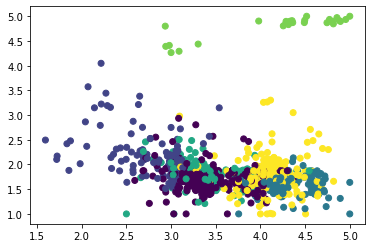

In [66]:
# creating the user's 'dream wine'
averages = df_top5.mean(axis=0,skipna=True,numeric_only=True)
averages.drop(['fizziness', 'review_count'], inplace=True)
print(averages)

# creating a numeric-only version of the wine data
wine_numeric = wines.select_dtypes(include=np.number)
wine_numeric = wine_numeric.fillna(wine_numeric.mean()) # note the fizziness imputation is meaningless
wine_numeric.drop(['fizziness', 'review_count'], axis=1, inplace=True)

# preprocessing/scaling features
x = wine_numeric.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
model = KMeans(n_clusters=6).fit(x_scaled) # 6 clusters/groups of wines
values, counts = np.unique(model.labels_, return_counts = True)
wine_numeric['cluster'] = model.labels_
wines['cluster'] = model.labels_
print(counts)

# visualize the clustering by acidity/sweetness
sweetness = wine_numeric['sweetness']
acidity = wine_numeric['acidity']
cluster = wine_numeric['cluster']
plt.scatter(x=acidity,y=sweetness,c=cluster)

The clustering with 6 groups looks good, at least in this view. Now onto predicting for our dream wine"

In [67]:
#dream_x = averages.values
#min_max_scaler = preprocessing.MinMaxScaler()
#dream_X = pd.DataFrame(dream_x)

dream_x = pd.DataFrame(averages.values.reshape(1,-1))
#print(dream_x)
results = model.predict(dream_x)
print("resulting cluster assignment for dream wine: ", results[0])

resulting cluster assignment for dream wine:  3


Our hypothetical dream wine has been assigned to cluster 2.

In [71]:
our_cluster = wines.loc[wines['cluster'] == 2]
print(our_cluster)

                                              name            type   acidity  \
id                                                                             
1171671                                    Margaux         Margaux  4.245219   
1619759                                    Margaux         Margaux  4.182982   
14362                  Pauillac (Grand Cru Classé)        Pauillac  4.196922   
1125543                Pauillac (Grand Cru Classé)        Pauillac  4.149271   
1152755  Pessac-Léognan (Premier Grand Cru Classé)  Pessac-Léognan  4.221047   
...                                            ...             ...       ...   
98074                                Saint-Estèphe   Saint-Estèphe  4.195325   
1101093                                   Pauillac        Pauillac  4.245596   
66114              Costa Russi (Barbaresco) Langhe      Barbaresco  4.649312   
66134              Sorì Tildìn (Barbaresco) Langhe      Barbaresco  4.696530   
66144                             Sorì S

Great! Now we have narrowed down our suggestions to 181. From here, we can probably look at flavor profiles to get a more specific range of recommendations.

In [72]:
preferred_flavors = {}
flavor1_list = df_top5['flavor1'].tolist()
flavor2_list = df_top5['flavor2'].tolist()
flavor3_list = df_top5['flavor3'].tolist()
flavor4_list = df_top5['flavor4'].tolist()
flavors_list = flavor1_list + flavor2_list + flavor3_list + flavor4_list
#print(flavors_list)

for flavor in flavors_list:
    if flavor not in preferred_flavors:
        preferred_flavors[flavor] = 1
    else:
        preferred_flavors[flavor] += 1

print(preferred_flavors) # how many times each flavor occurs in our top 5
mylist = sorted(preferred_flavors, key=preferred_flavors.get, reverse=True)
print(mylist) # our user's top flavors, sorted from most-occurring to least

{'oak': 4, 'blackberry': 3, 'black fruit': 1, 'vanilla': 5, 'honey': 1, 'cedar': 1, 'plum': 2, 'cherry': 1, 'caramel': 1, 'smoke': 1}
['vanilla', 'oak', 'blackberry', 'plum', 'black fruit', 'honey', 'cedar', 'cherry', 'caramel', 'smoke']


In [76]:
our_cluster = wines.loc[wines['cluster'] == 2]
flavored_suggestions = our_cluster.loc[our_cluster['flavor1'].isin(mylist)]
#flavored_suggestions = flavored_suggestions[:5]
print(flavored_suggestions)

                                                  name           type  \
id                                                                      
1171671                                        Margaux        Margaux   
4978718                                 Brunate Barolo         Barolo   
2716528  Le Petit Mouton de Mouton Rothschild Pauillac       Pauillac   
1179603              La Dame de Montrose Saint-Estèphe  Saint-Estèphe   
6020                 Pavillon Rouge du Château Margaux        Margaux   
...                                                ...            ...   
779608                         Vigna Colonnello Barolo         Barolo   
79876             Sarget de Gruaud Larose Saint-Julien   Saint-Julien   
1148646                                  Listrac-Médoc  Listrac-Médoc   
1137679                 Connétable Talbot Saint-Julien   Saint-Julien   
1101093                                       Pauillac       Pauillac   

          acidity  fizziness  intensity  sweetness

Now that it's been narrowed down to 82 wines with ideal flavors, let's take into account price: